In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.tensorboard import SummaryWriter
from time import time

import utils.data as du
import utils.training as tut
from utils.models.cwgangp import Critic, Generator, initialize_weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 1.10.2
Device: cuda


In [2]:
LATENT_DIM = 4
GEN_EMBEDDING = 128
EPOCHS = 5

BATCH_SIZE = 256
LEARNING_RATE = 1e-4
CHANNELS_IMG = 1
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
NUM_CLASSES = None
IMG_SIZE = 9
LAMBDA_GP = 10
INFO_FREQ = 2

CHECKPOINT_PATH = f"./checkpoints/cwgan_ld{LATENT_DIM}_checkpoint.pth.tar"

In [3]:
detectors_signals, arrival_times, logE, mass, xmax = du.get_data()

# arrival_times = du.proposedArrivalTimesNorm(arrival_times)
shower_maps = du.arrivalTimesDomMap(arrival_times)
shower_maps = shower_maps.reshape(-1, 1, 9, 9)
# total_signals = du.proposedTotalSignals(detectors_signals)

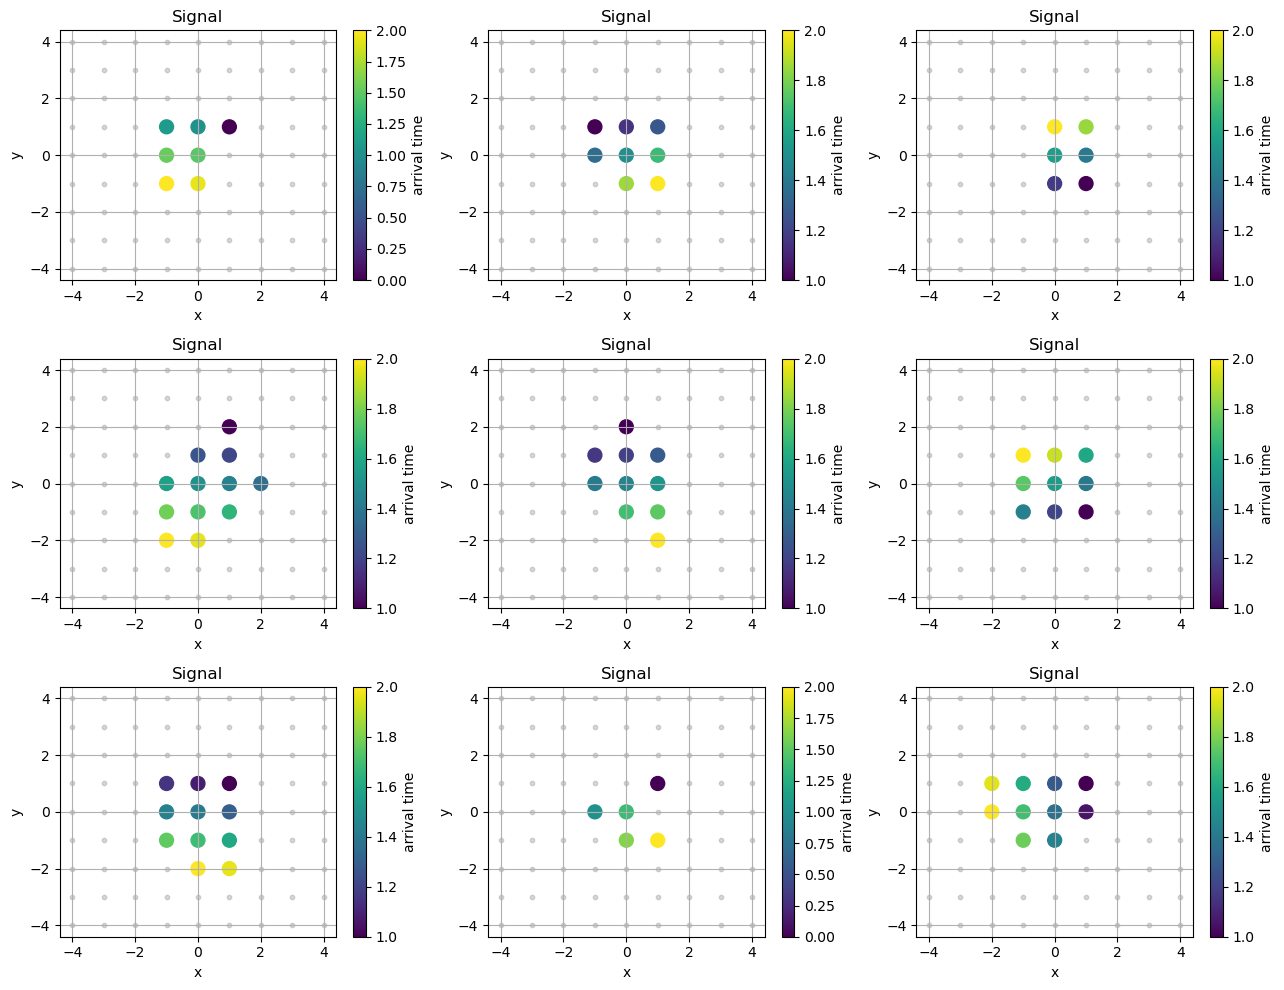

In [4]:
plot = du.plot_signals_arrival_times(shower_maps, N=3, random=False, show=True)

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
mass = encoder.fit_transform(mass)
NUM_CLASSES = len(encoder.classes_)

In [6]:
import pandas as pd
df = pd.DataFrame({"mass":mass, "Xmax":xmax, "logE":logE })
df["cat_logE"] = pd.cut(df["logE"], bins=4, labels=["E1", "E2", "E3", "E4"])
cat_logE = df["cat_logE"].to_numpy()

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cat_logE = encoder.fit_transform(cat_logE)
NUM_CLASSES = len(encoder.classes_)
NUM_CLASSES

4

In [7]:
x = torch.from_numpy(shower_maps).type(torch.float32)
y = torch.from_numpy(cat_logE).type(torch.int64)

train_set = TensorDataset(x, y)

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)


writer_fake = SummaryWriter(f"logs/CWGANGP_LD{LATENT_DIM}_EAS/fake")
writer_real = SummaryWriter(f"logs/CWGANGP_LD{LATENT_DIM}_EAS/real")
writer_scalar = SummaryWriter(f"logs/CWGANGP_LD{LATENT_DIM}_EAS/loses")

In [8]:
gen_model = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING, "Conv-Generator").to(device)
critic_model = Critic(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE, "Conv-Critic").to(device)
fixed_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)
initialize_weights(gen_model)
initialize_weights(critic_model)

for model in [gen_model, critic_model]:
    tut.print_model_summary(model)

opt_gen = optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9) )
opt_critic = optim.Adam(critic_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9) )

Block name: Conv-Generator
----------------------------------------
 | LayerName | 	 | Size | 	 | Nparams | 
gen_net.0.0.weight: 	 (256, 256, 3, 3), 	 589824
gen_net.0.1.weight: 	 (256,), 	 256
gen_net.0.1.bias: 	 (256,), 	 256
gen_net.0.1.running_mean: 	 (256,), 	 256
gen_net.0.1.running_var: 	 (256,), 	 256
gen_net.0.1.num_batches_tracked: 	 (), 	 1
gen_net.1.0.weight: 	 (256, 256, 3, 3), 	 589824
gen_net.1.1.weight: 	 (256,), 	 256
gen_net.1.1.bias: 	 (256,), 	 256
gen_net.1.1.running_mean: 	 (256,), 	 256
gen_net.1.1.running_var: 	 (256,), 	 256
gen_net.1.1.num_batches_tracked: 	 (), 	 1
gen_net.2.0.weight: 	 (256, 128, 3, 3), 	 294912
gen_net.2.1.weight: 	 (128,), 	 128
gen_net.2.1.bias: 	 (128,), 	 128
gen_net.2.1.running_mean: 	 (128,), 	 128
gen_net.2.1.running_var: 	 (128,), 	 128
gen_net.2.1.num_batches_tracked: 	 (), 	 1
gen_net.3.0.weight: 	 (128, 128, 3, 3), 	 147456
gen_net.3.1.weight: 	 (128,), 	 128
gen_net.3.1.bias: 	 (128,), 	 128
gen_net.3.1.running_mean: 	 (128,), 	

In [9]:
step = 0

gen_model.train()
critic_model.train()

for epoch in range(EPOCHS):
    start_time = time()
    for batch_idx, (real, labels) in enumerate(train_loader):
        real = real.to(device)
        current_batch_size = real.shape[0]
        labels = labels.to(device)

        # Train critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(current_batch_size, LATENT_DIM, 1, 1).to(device)
            fake = gen_model(noise, labels)
            critic_real = critic_model(real, labels).reshape(-1)
            critic_fake = critic_model(fake, labels).reshape(-1)
            gp = tut.gradient_penalty(critic_model, real, fake, device=device, labels=labels)
            loss_critic = ( -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp )
            critic_model.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
        
        # Train generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic_model(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen_model.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        tut.print_batches_progress_bar(batch_idx, len(train_loader))
        
        info_dict = {"Loss Critic": loss_critic, "Loss G": loss_gen}

        gen_model.eval()
        critic_model.eval()

        if batch_idx == 0:
            with torch.no_grad():
                fake = gen_model(noise,labels)
                data = real
                data_labels = labels

                fake = fake.cpu().numpy()
                data = data.cpu().numpy()
                data_labels = data_labels.cpu().numpy()

                fake_showers_fig = du.plot_signals_arrival_times(fake,data_labels, N=3 )
                real_showers_fig = du.plot_signals_arrival_times(data,data_labels, N=3 )

                writer_fake.add_figure("Fake showers", fake_showers_fig, global_step=epoch)
                writer_real.add_figure("Real showers", real_showers_fig, global_step=epoch)

        with torch.no_grad():
            writer_scalar.add_scalar("Loss/Critic", loss_critic.cpu().item(), global_step=step )
            writer_scalar.add_scalar("Loss/Gen", loss_gen.cpu().item() , global_step=step )
            
        gen_model.train()
        critic_model.train()
        step += 1
    
    elapsed_time = time() - start_time
    info_dict["time"] = elapsed_time
    tut.print_epoch_info(epoch, EPOCHS, INFO_FREQ, info_dict)

[======================================================================>] 100%, batch 391 	
--------------------------------------------------------------------------------------
| Epoch: [001/005] | Loss Critic: -0.5036 | Loss G: 4.9796 | time: 83.27s | 
--------------------------------------------------------------------------------------

[======================================================================>] 100%, batch 391 	
--------------------------------------------------------------------------------------
| Epoch: [003/005] | Loss Critic: -0.5197 | Loss G: 3.3522 | time: 84.12s | 
--------------------------------------------------------------------------------------

[======================================================================>] 100%, batch 391 	
--------------------------------------------------------------------------------------
| Epoch: [005/005] | Loss Critic: -0.3379 | Loss G: 2.8608 | time: 80.99s | 
--------------------------------------------------------

In [10]:
%load_ext tensorboard
%tensorboard --logdir=logs/CWGANGP_LD128_EAS

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12742), started 0:00:01 ago. (Use '!kill 12742' to kill it.)

In [12]:
tut.save_checkpoint(5, [critic_model, gen_model], [opt_critic, opt_gen], [loss_critic, loss_gen], filename=CHECKPOINT_PATH)

In [11]:
checkpoint = tut.get_checkpoint(CHECKPOINT_PATH, True)

Key: 'epoch'
Key: 'Conv-Critic_0_state_dict'
Key: 'Conv-Generator_1_state_dict'
Key: 'optimizer_0_state_dict'
Key: 'optimizer_1_state_dict'
Key: 'loss_0'
Key: 'loss_1'


In [12]:
tut.load_state_dicts(checkpoint, models=[critic_model,gen_model])

Success


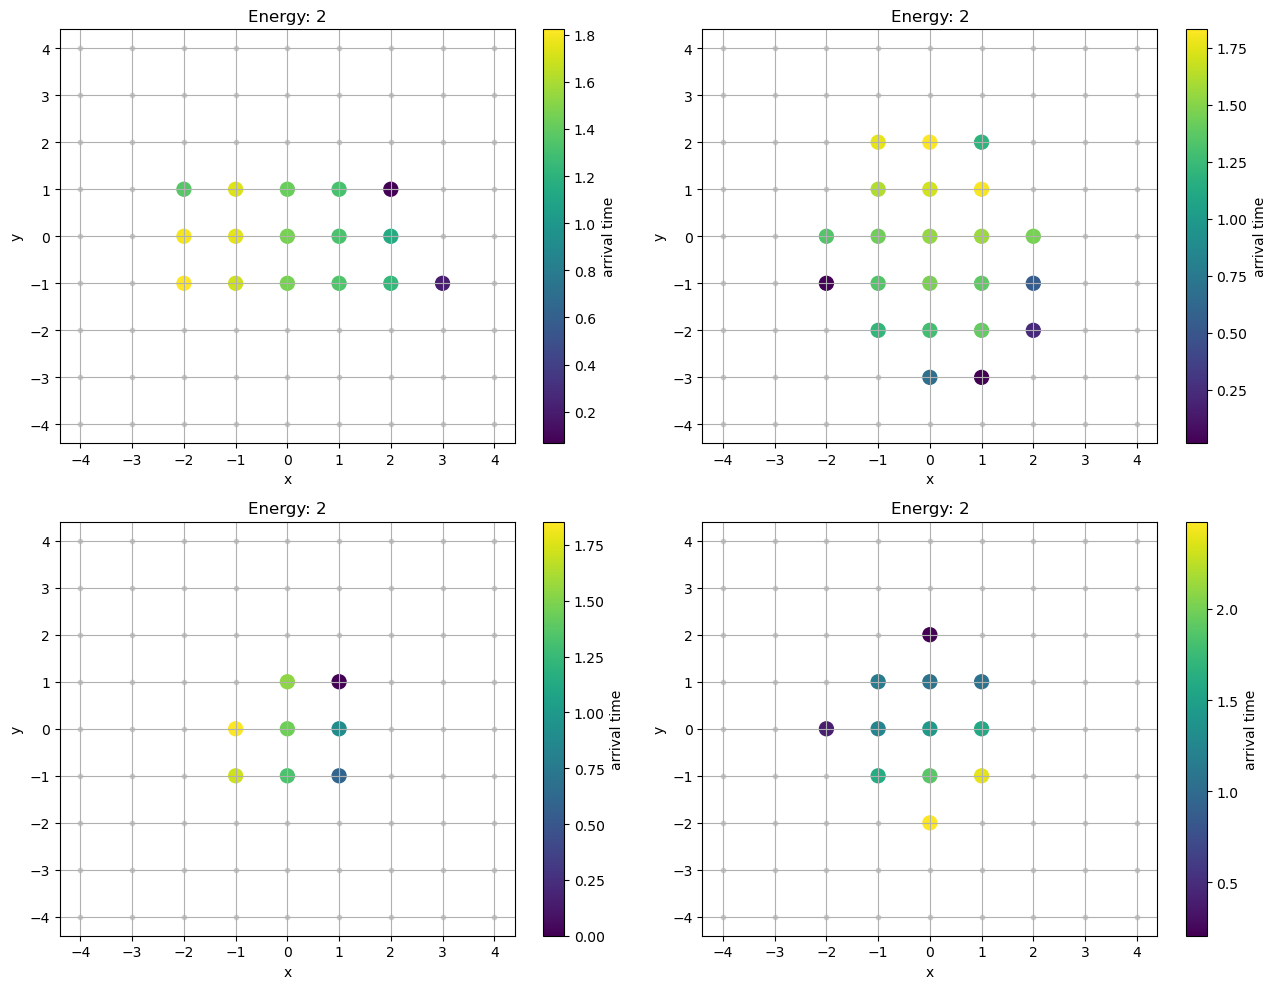

In [21]:
N_samples = 256
gen_model.eval()
noise = torch.randn(N_samples, LATENT_DIM, 1, 1).to(device=device)
labels = torch.randint(2,4,(256,)).to(device=device)
with torch.no_grad():
    fake = gen_model(noise,labels)

fake = fake.cpu().numpy()
labels = labels.cpu().numpy()
fake_showers_fig = du.plot_signals_arrival_times(fake, labels, N=2,show=True )